In [219]:
#%pip install statsmodels
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 294.9/294.9 kB 9.2 MB/s eta 0:00:00


In [403]:
import os

import pandas as pd
import geopandas as gpd
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.optimize import curve_fit

#### Loading taxi dataset

In [4]:
folderpath = "C:/Users/anape/nyc-taxi/data/"
files = os.listdir(folderpath)
parquet_files = [file for file in files if file.endswith('.parquet')]

dataframes = [pd.read_parquet(os.path.join(folderpath, p_file)) for p_file in parquet_files]

for df in dataframes:
    for column in df.columns:
        df.rename(columns={column: column.lower()}, inplace=True)

df2023 = pd.concat([df for df in dataframes], axis=0, ignore_index=True)
# df2023.info()

In [465]:
pd.concat([df for df in dataframes], axis=0, ignore_index=True).shape

(38310226, 19)

In [8]:
df2023['month'] = df2023['tpep_pickup_datetime'].dt.month
df2023['month_name'] = df2023['tpep_pickup_datetime'].dt.month_name()

df2023['dayofweek'] = df2023['tpep_pickup_datetime'].dt.day_of_week
df2023['day_name'] = df2023['tpep_pickup_datetime'].dt.day_name()

df2023['time'] = df2023['tpep_pickup_datetime'].dt.hour
df2023['dayofyear'] = df2023['tpep_pickup_datetime'].dt.dayofyear

df2023['year'] = df2023['tpep_pickup_datetime'].dt.year


In [24]:
df2023.loc[:, 'duration'] = df2023['tpep_dropoff_datetime'] - df2023['tpep_pickup_datetime']

In [25]:
df2023 = df2023[df2023['duration'] > pd.Timedelta(minutes=5)]
df2023 = df2023[df2023['duration'] < pd.Timedelta(hours=5)]

In [9]:
print('Initially, the dataset contains entries from the years:',df2023['year'].unique())

# removing entries from different years
df2023 = df2023[df2023['year'] == 2023]

Initially, the dataset contains entries from the years: [2023 2022 2008 2009 2003 2001 2014 2002 2024]


In [10]:
df2023[['year', 'week', 'day']] = df2023['tpep_pickup_datetime'].dt.isocalendar()[['year', 'week', 'day']]

In [464]:
df2023.shape

(33940989, 29)

In [26]:
counts = df2023.groupby(['year','week','day']).size()

In [358]:
# for plotting purposes
xticks = [0,31,59,90,120,151,181,212,243,273,304,334]
xtickslabels = ['Jan', 'Feb', 'Mar', 'Apr',
                'May', 'Jun', 'Jul', 'Aug',
                'Sep', 'Oct', 'Nov', 'Dec']

## Trend

In [371]:
x = np.arange(len(counts))
y = counts.values

In [396]:
degrees = [2,3,4,5] # polynomial degree

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


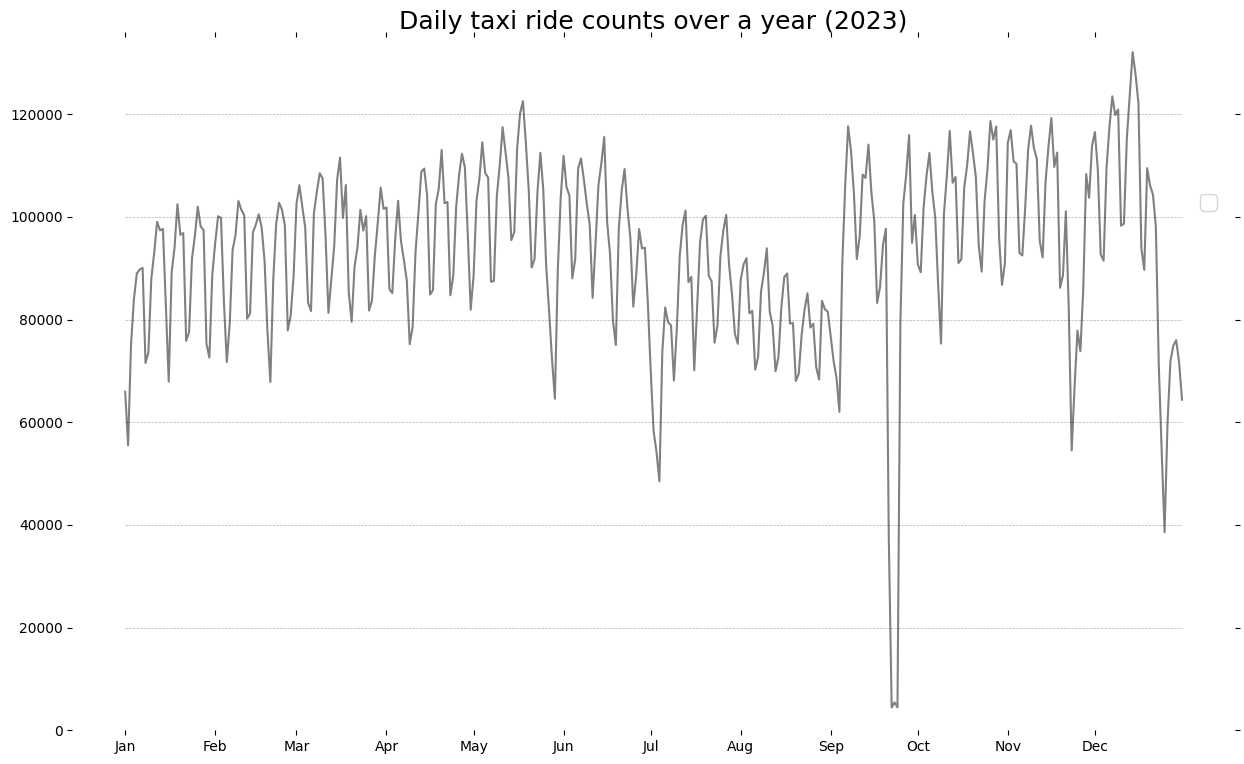

In [466]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(counts.values, color = 'gray')
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.75), fontsize = 15)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=10)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Daily taxi ride counts over a year (2023)',
          fontsize = 18)
plt.show()


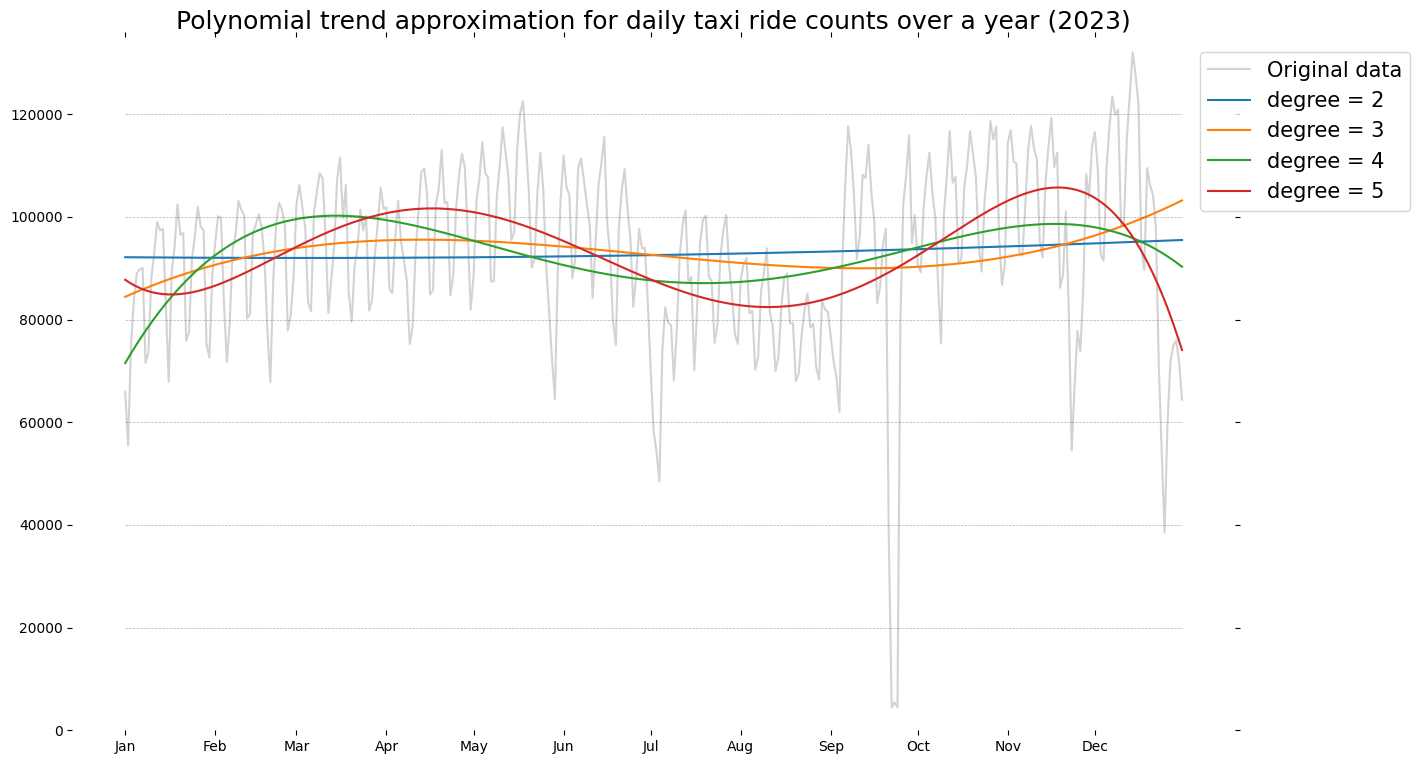

In [415]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(counts.values, color = 'lightgray', label = 'Original data')
for d in degrees:
    coef_t = np.polyfit(x,y, deg = d)
    poly_t = np.poly1d(coef_t)
    trend = pd.Series(data = poly_t(x), index = counts.index)
    ax.plot(trend.values, label = f'degree = {d}')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.75), fontsize = 15)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=10)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Polynomial trend approximation for daily taxi ride counts over a year (2023)',
          fontsize = 18)
plt.show()


In [ ]:
coef_t = np.polyfit(x,y, deg = 5)
poly_t = np.poly1d(coef_t)
trend = pd.Series(data = poly_t(x), index = counts.index)

## Curve optimization

In [409]:
def sinusoidal(x, A, omega, phi, offset):
    return A * np.sin(omega * x + phi) + offset

# Initial guess for the parameters
p0 = [1, 0, 0, 0] 

params, covariance = curve_fit(sinusoidal, x, y, p0=p0)

# Extract the fitted parameters
A, omega, phi, offset = params

# Generate the fitted curve
y_fit = sinusoidal(x, A, omega, phi, offset)

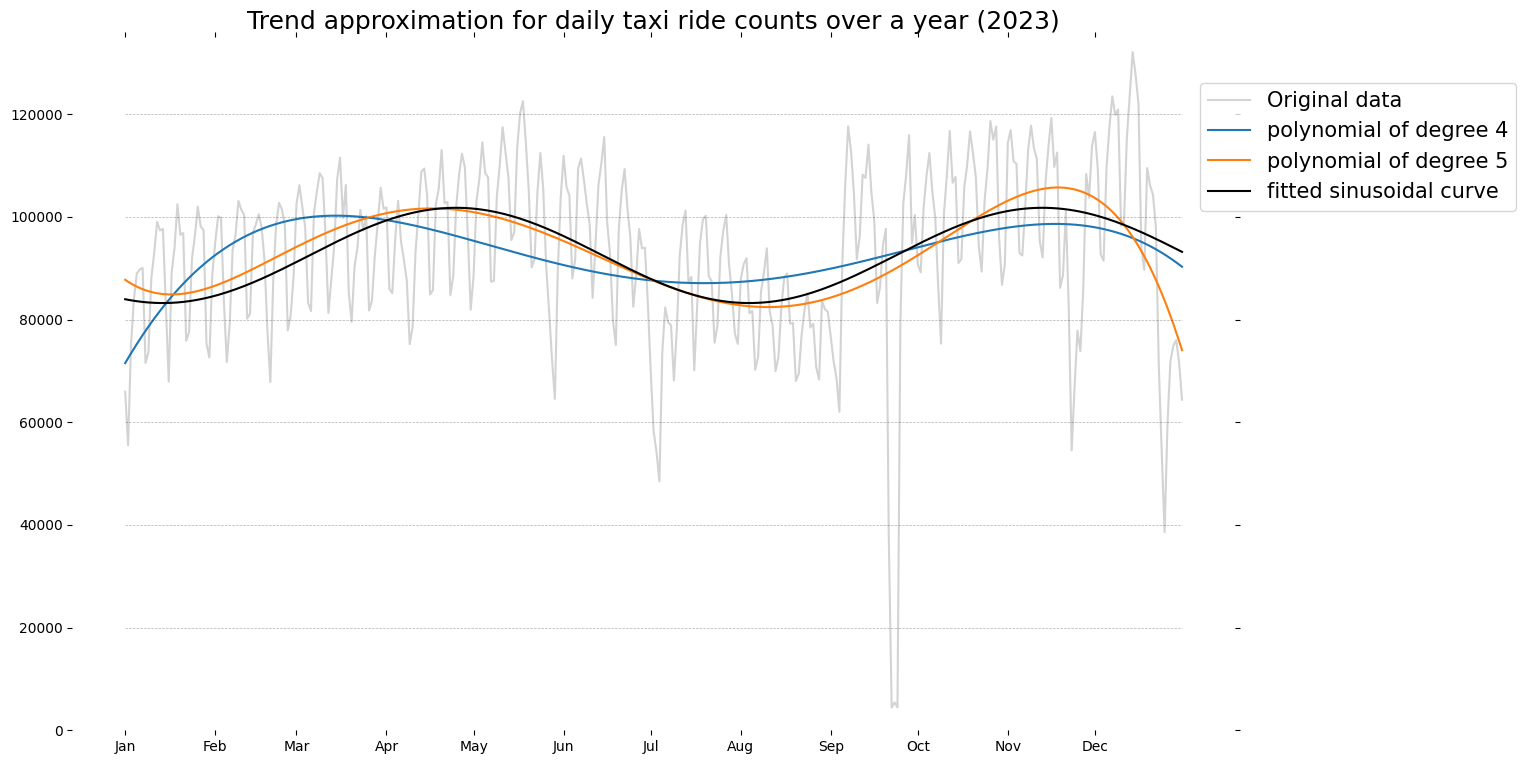

In [431]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(counts.values, color = 'lightgray', label = 'Original data')
for d in [4,5]:
    coef_t = np.polyfit(x,y, deg = d)
    poly_t = np.poly1d(coef_t)
    trend = pd.Series(data = poly_t(x), index = counts.index)
    ax.plot(trend.values, label = f'polynomial of degree {d}')
ax.plot(x, y_fit, color='black', label='fitted sinusoidal curve')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.75), fontsize = 15)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=10)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Trend approximation for daily taxi ride counts over a year (2023)',
          fontsize = 18)
plt.show()


In [418]:
trend = pd.Series(data = y_fit, index = counts.index)

In [419]:
detrended = counts.copy()
detrended = detrended - trend.values

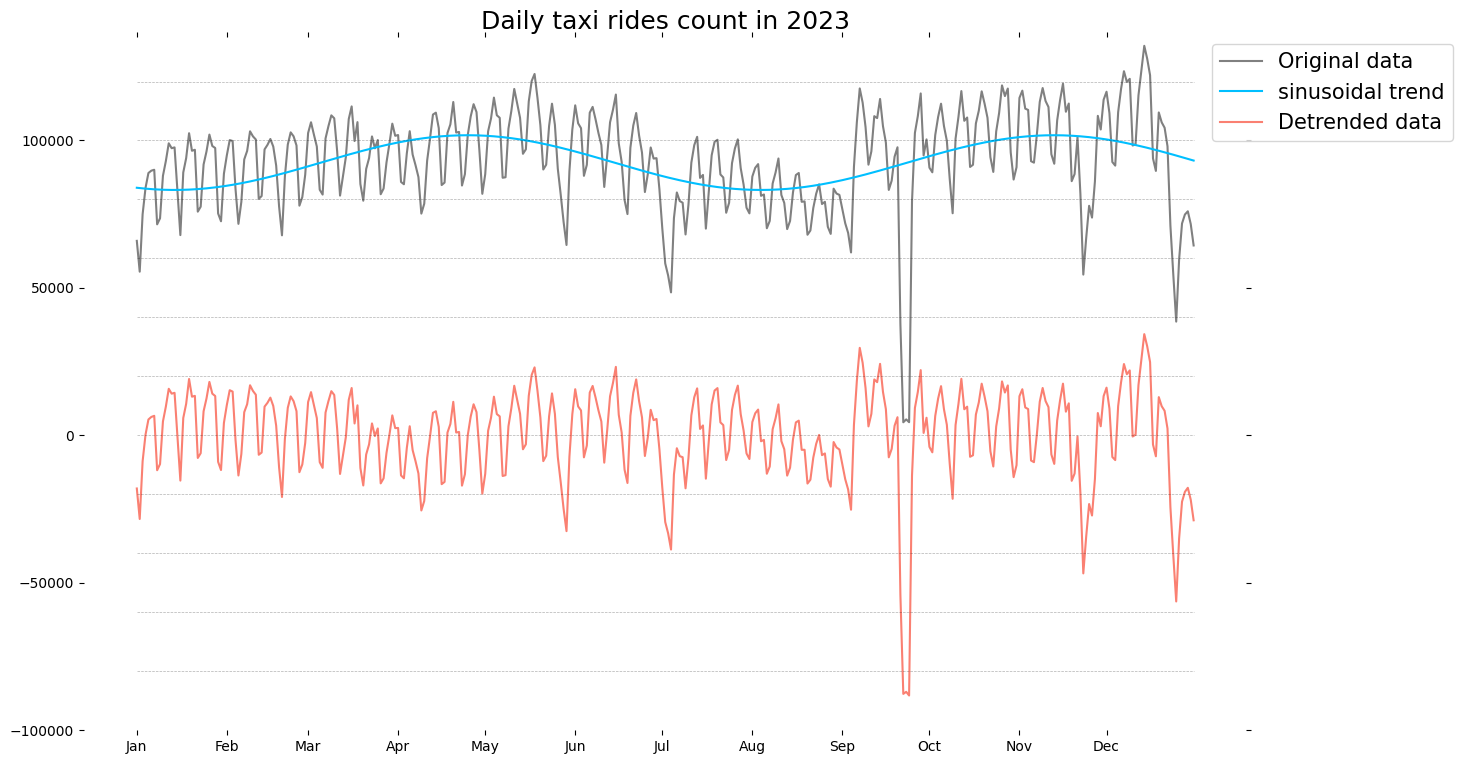

In [421]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(counts.values, color = 'gray', label = 'Original data')
ax.plot(trend.values, color = 'deepskyblue', label = 'sinusoidal trend')
ax.plot(detrended.values, color = 'salmon', label = 'Detrended data')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.85), fontsize = 15)

plt.ylim(-100000, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=10)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(-80000, 135000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Daily taxi rides count in 2023',
          fontsize = 18)
plt.show()

## Season
### Week

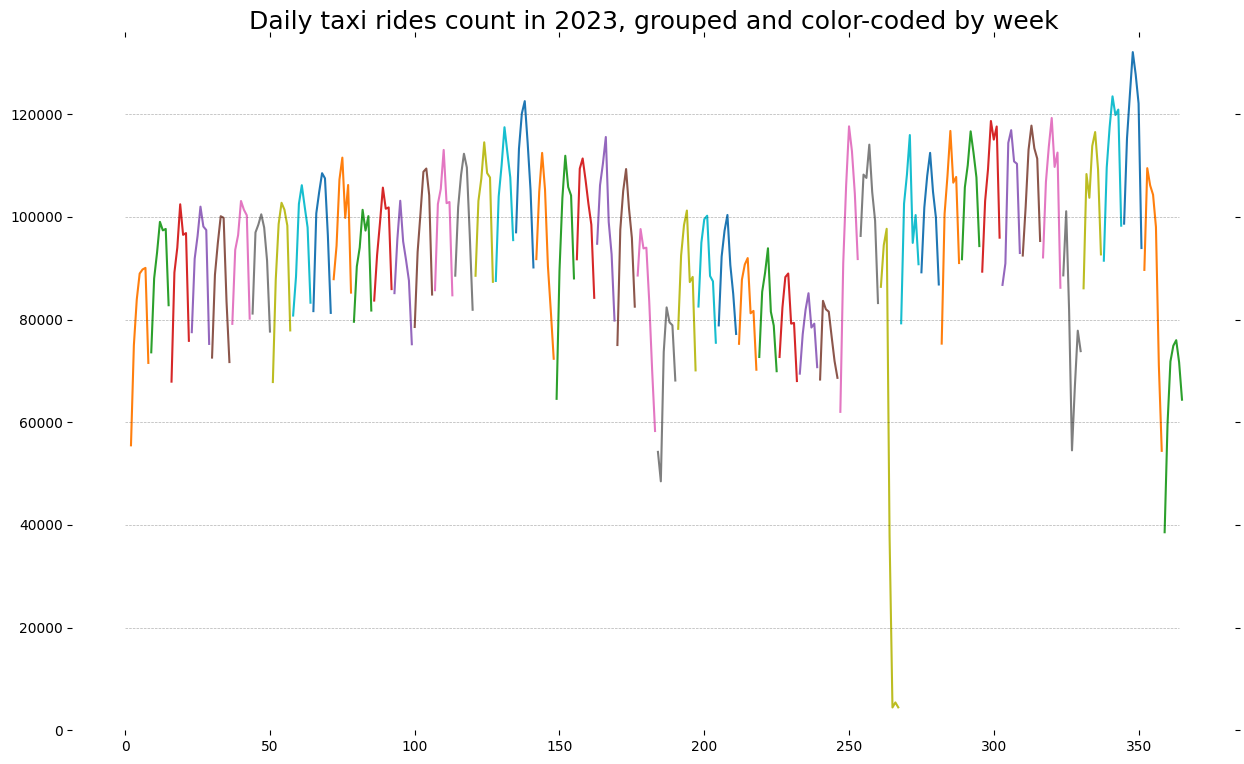

In [230]:
fig, ax= plt.subplots(figsize = (15, 9))
for m, group in df2023.groupby(['year','week']):
    data = group.dayofyear.value_counts(sort = False).sort_index()
    ax.plot(data)
# plt.legend(ncol=3, fontsize = 'small')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize = 10)  
plt.yticks(fontsize = 10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Daily taxi rides count in 2023, grouped and color-coded by week',
          fontsize = 18)
plt.show()


In [422]:
weekly_mean = detrended.groupby(level = 2).mean()
weekly_median = detrended.groupby(level = 2).median()

In [423]:
weekly_trend = detrended.copy()
for i in weekly_median.index:
    weekly_trend.loc[weekly_trend.index.get_level_values('day') == i] = weekly_median.loc[i]

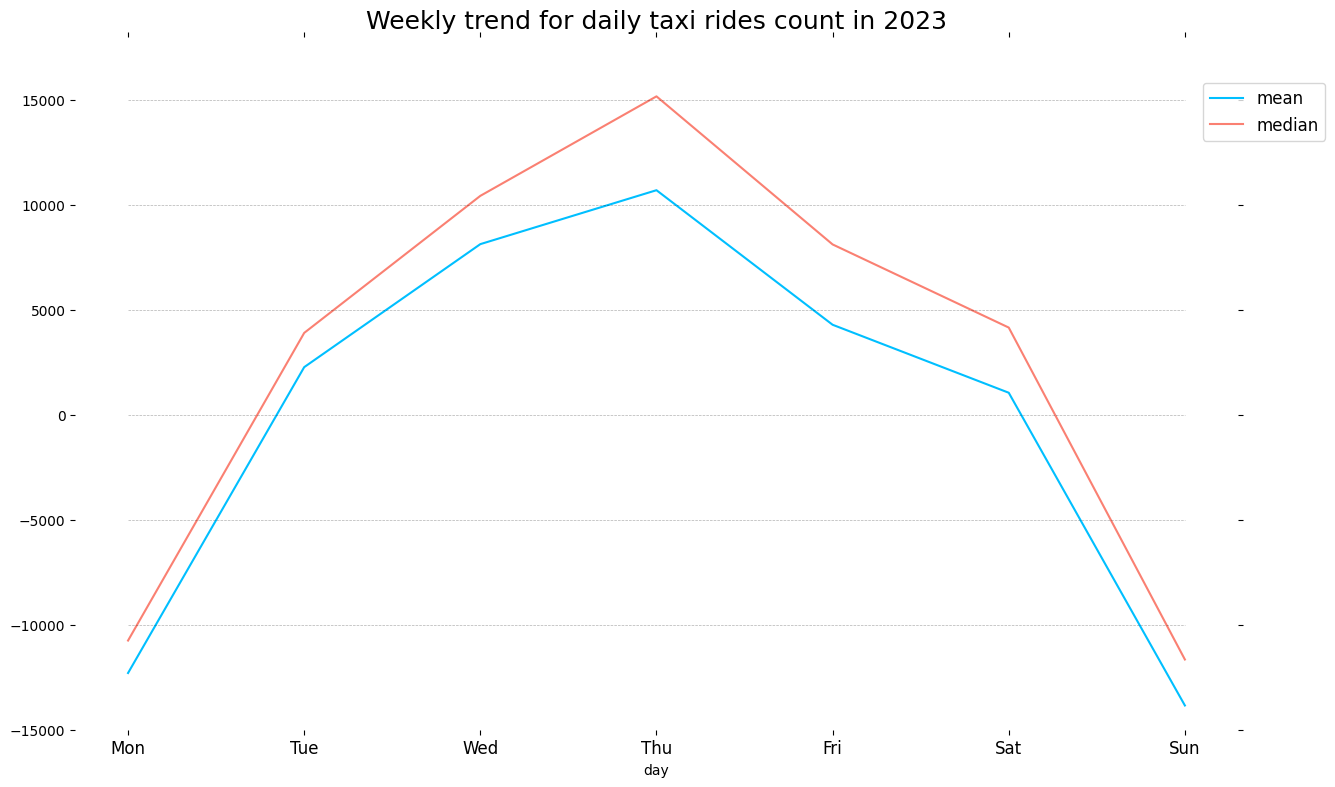

In [456]:
fig, ax= plt.subplots(figsize = (15, 9))
weekly_mean.plot(color = 'deepskyblue', label = 'mean')
weekly_median.plot(color = 'salmon', label = 'median')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)

plt.legend(loc = (0.97,0.85), fontsize = 12)

plt.ylim(-15000, 18000)  
# plt.xlim(0, 365)
plt.xticks(weekly_mean.index, labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(-15000, 20000, 5000):  
    plt.plot(range(1, 8), [j] * len(range(1, 8)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Weekly trend for daily taxi rides count in 2023',
          fontsize = 18)
plt.show()

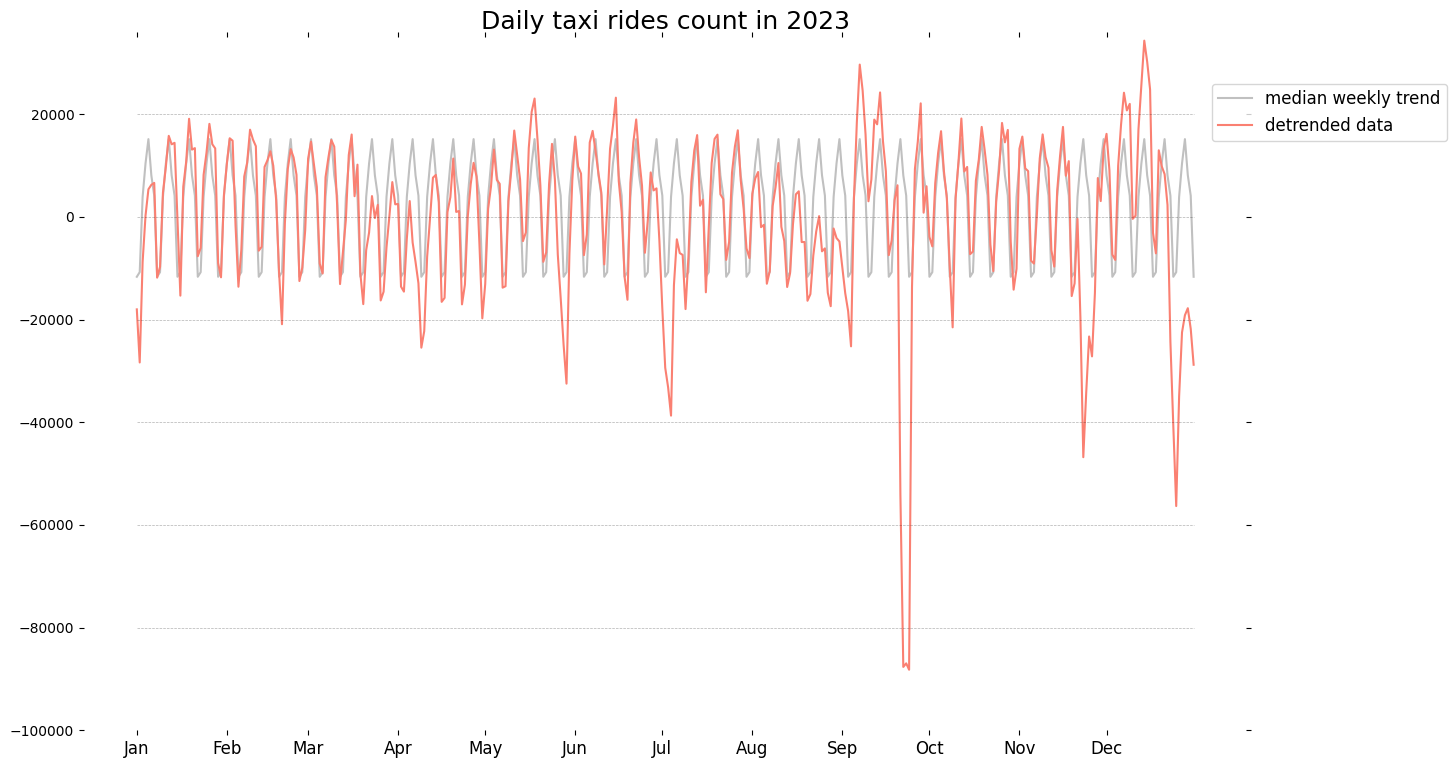

In [457]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(weekly_trend.values, color = 'silver', label = 'median weekly trend')
ax.plot(detrended.values, color = 'salmon', label = 'detrended data')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.85), fontsize = 12)

plt.ylim(-100000, 35000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=12)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(-80000, 35000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Daily taxi rides count in 2023',
          fontsize = 18)
plt.show()

In [426]:
deseasoned_w = detrended.copy()
deseasoned_w = deseasoned_w - weekly_trend.values

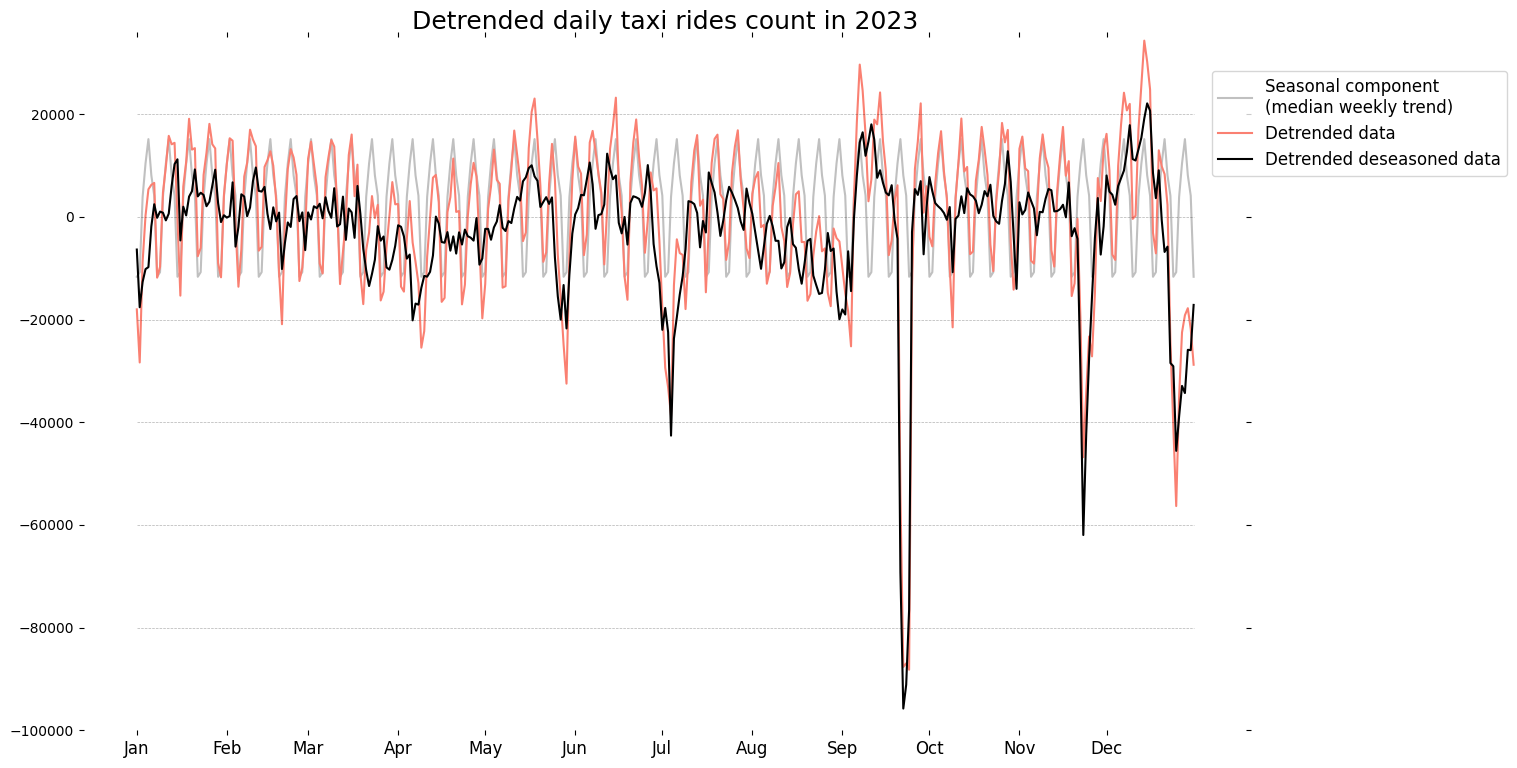

In [427]:
fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(weekly_trend.values, color = 'silver', label = 'Seasonal component \n(median weekly trend)')
ax.plot(detrended.values, color = 'salmon', label = 'Detrended data')
ax.plot(deseasoned_w.values, color = 'black', label = 'Detrended deseasoned data')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.80), fontsize = 12)

plt.ylim(-100000, 35000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=12)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(-80000, 35000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Detrended daily taxi ride counts over a year (2023)',
          fontsize = 18)
plt.show()

In [428]:
reconstructed = weekly_trend.copy()
reconstructed = reconstructed + trend.values 

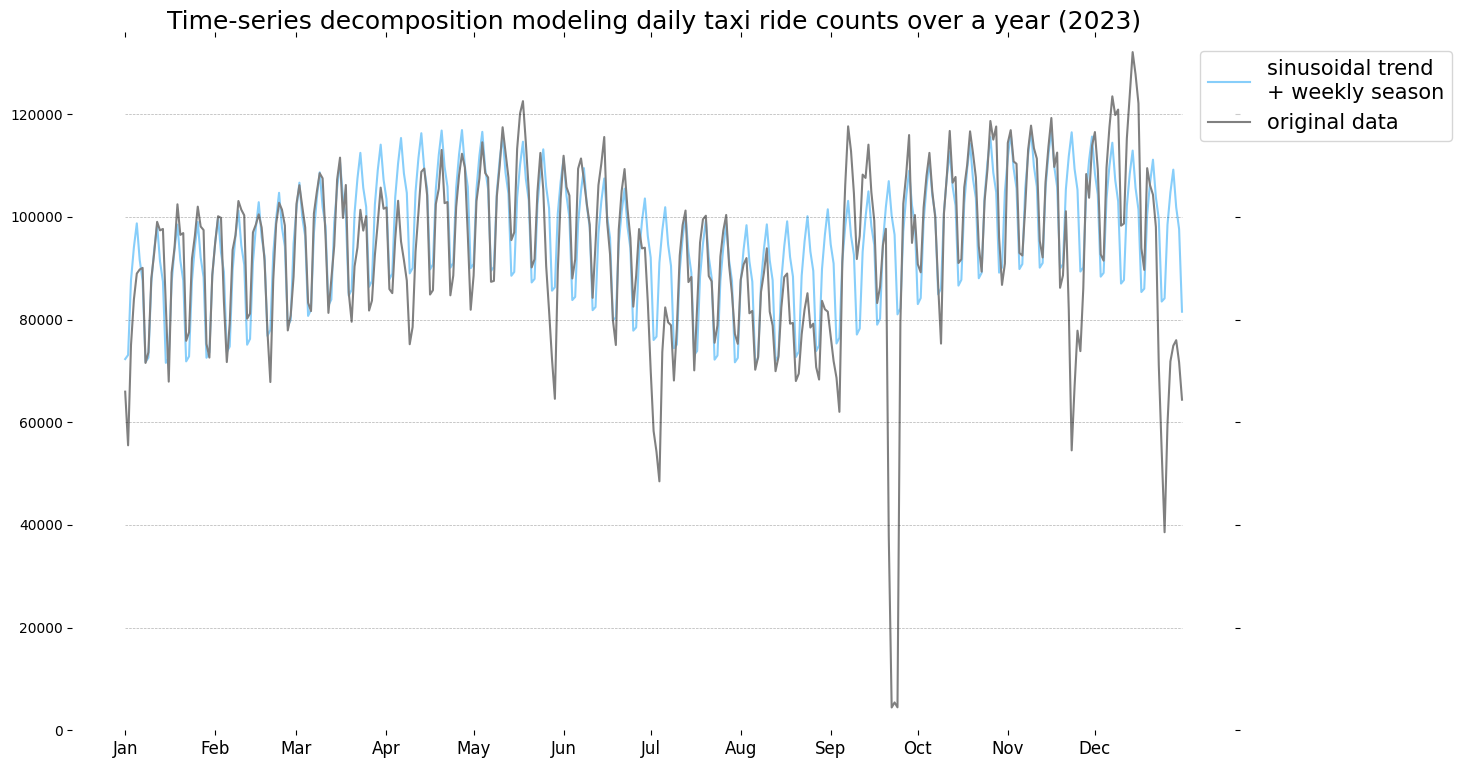

In [460]:

fig, ax= plt.subplots(figsize = (15, 9))
ax.plot(reconstructed.values, color = 'lightskyblue', label = 'sinusoidal trend\n+ weekly season')
ax.plot(counts.values, color = 'gray', label = 'original data')

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)


plt.legend(loc = (0.97,0.85), fontsize = 15)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=12)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Time-series decomposition modeling daily taxi ride counts over a year (2023)',
          fontsize = 18)
plt.show()

## Season
### Month

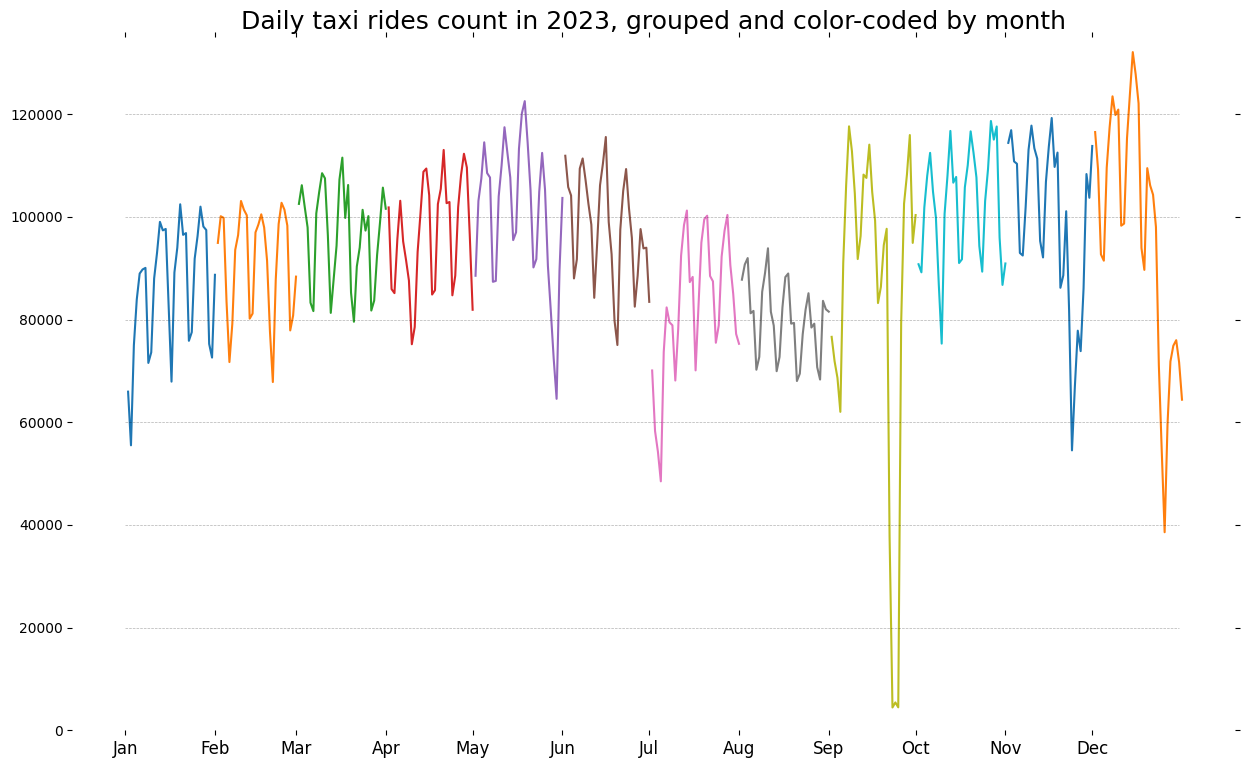

In [366]:
fig, ax= plt.subplots(figsize = (15, 9))
for m, group in df2023.groupby('month'):
    data = group.dayofyear.value_counts(sort = False).sort_index()
    ax.plot(data)
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)

plt.ylim(0, 135000)  
# plt.xlim(0, 365)
plt.xticks(xticks, xtickslabels, fontsize=12)  
plt.yticks(fontsize=10)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")   

for j in range(0, 130000, 20000):  
    plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)  


plt.title('Daily taxi rides count in 2023, grouped and color-coded by month',
          fontsize = 18)
plt.show()


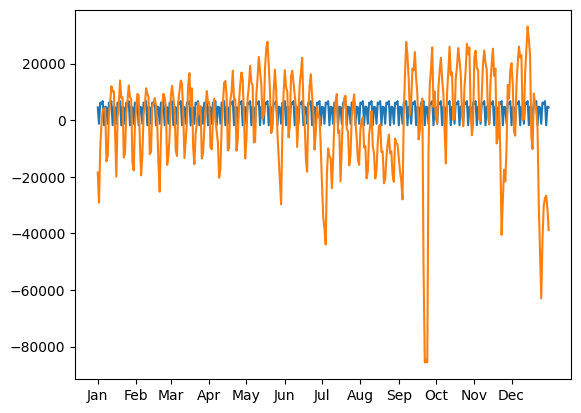

In [365]:
monthly_median = detrended.groupby(level = 1).median()
monthly_trend = detrended.copy()
for i in monthly_median.index:
    monthly_trend.loc[monthly_trend.index.get_level_values('day') == i] = monthly_median.loc[i]
plt.xticks(xticks, xtickslabels, )
plt.plot(monthly_trend.values)
plt.plot(detrended.values)
plt.show()

In [200]:
deseasoned_m = deseasoned_w.copy()
deseasoned_m = deseasoned_m - monthly_trend.values

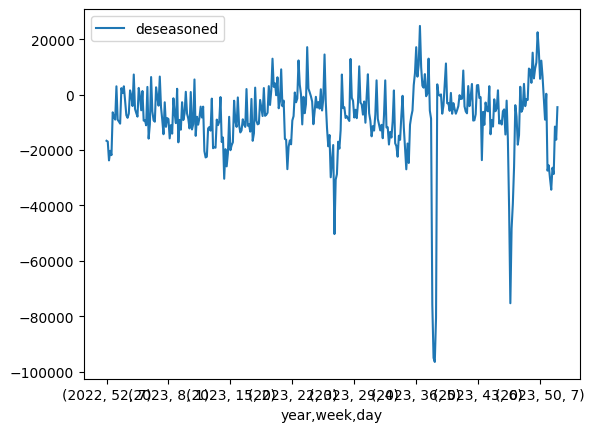

In [201]:
# plt.plot(counts.values, label = 'Original data')
# plt.plot(trend.values, label = 'Trend')
# #plt.plot(detrended.values, label = 'Detrended')
# weekly_trend.plot(label='seasonal trend')
# monthly_trend.plot(label='seasonal trend')
#detrended.plot(label='detrended')
deseasoned_m.plot(label='deseasoned')
plt.legend()
plt.show()

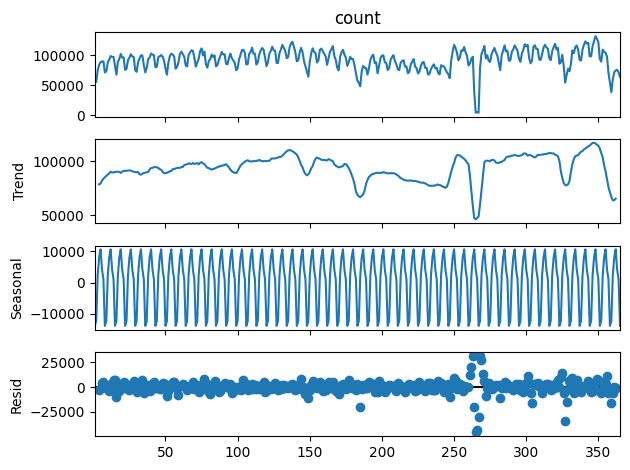

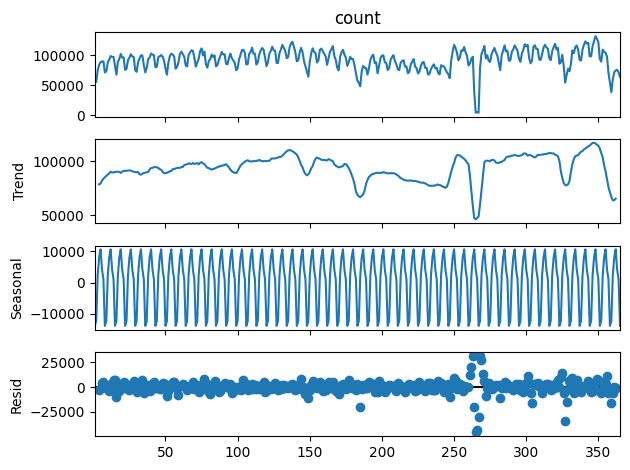

In [467]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df2023.dayofyear.value_counts(sort = False).sort_index(), period = 7)
res.plot()

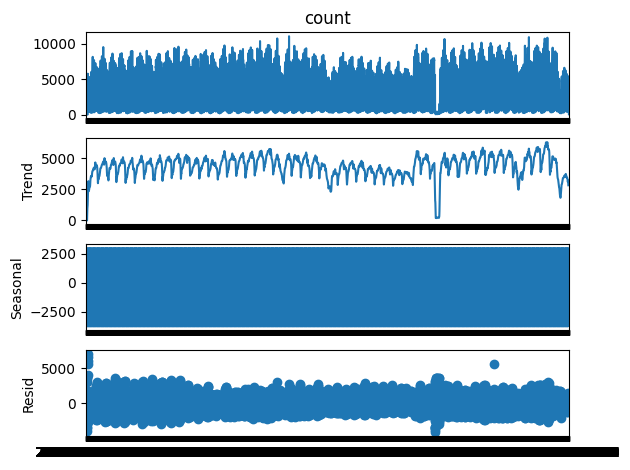

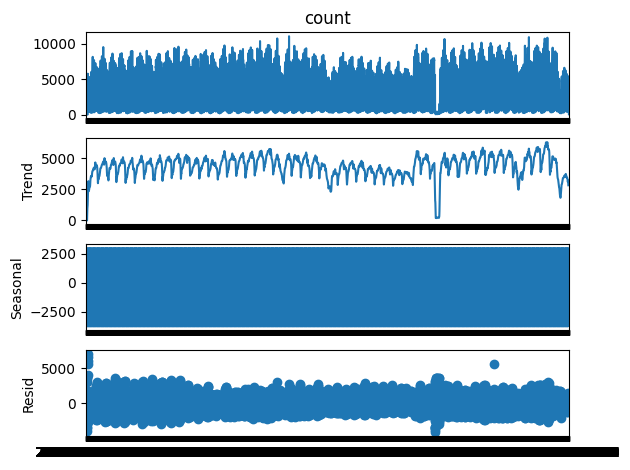

In [54]:
res = sm.tsa.seasonal_decompose(df2023.date_and_hour.value_counts(sort = False).sort_index(), period = 24)
res.plot()

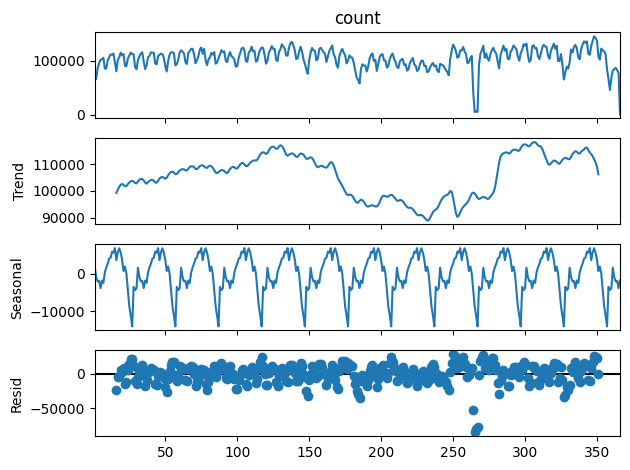

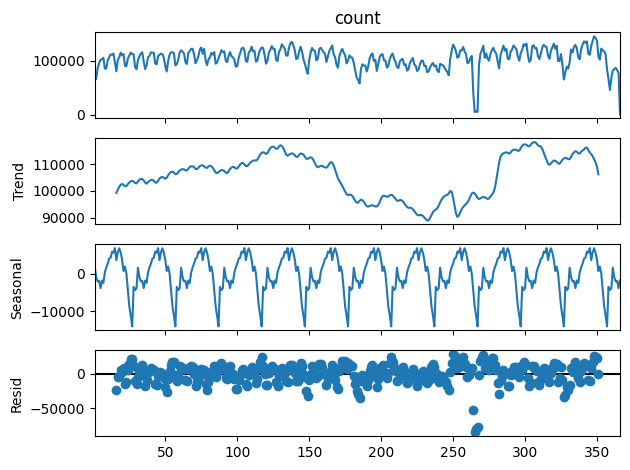

In [53]:
res = sm.tsa.seasonal_decompose(df2023.dayofyear.value_counts(sort = False).sort_index(), period = 30)
res.plot()